<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/03.05-Continuous-Stirred-Tank-Reactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuous Stirred-Tank Reactor

This notebook shows how to use functions from `sympy`to symbolic solve a dynamic model presented in Seborg 4<sup>th</sup> ed. p. 26.

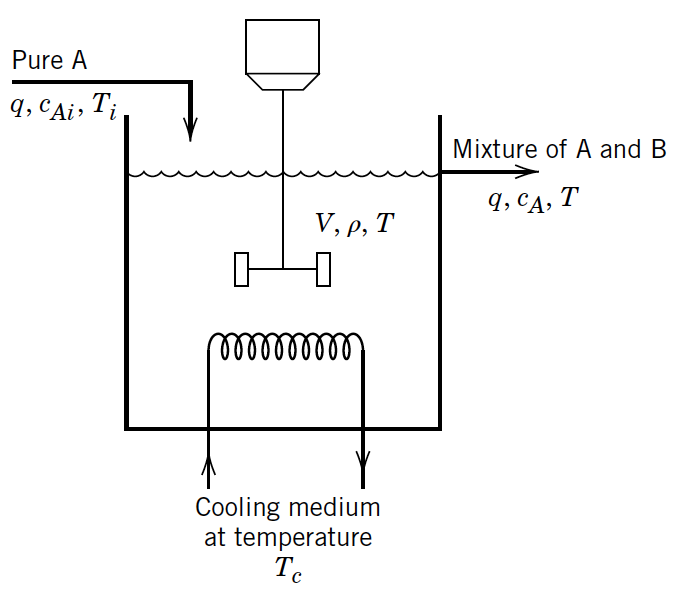

In [1]:
from sympy import *
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
t, q, c_A, c_A_dot, T, T_dot, T_c, c_Ai, T_i, V, rho, k_0, EoverR, C, DHR, UA = symbols('t, q, c_A, \dot{c}_A, T, \dot{T}, T_c, c_{Ai}, T_i, V, \\rho, k0, EoverR, C, {\\Delta}H_R, UA')

Equation 2-66

In [3]:
c_A_dot_ = Eq(c_A_dot, (1/V)*(q*(c_Ai - c_A) - V*k_0*exp(-EoverR/T)*c_A))
c_A_dot_

Eq(\dot{c}_A, (-V*c_A*k0*exp(-EoverR/T) + q*(-c_A + c_{Ai}))/V)

Equation 2-68

In [4]:
T_dot_ = Eq(T_dot, (1/(V*rho*C))*(rho*q*C*(T_i - T) + DHR*V*k_0*exp(-EoverR/T)*c_A + UA*(T_c - T)))
T_dot_

Eq(\dot{T}, (C*\rho*q*(-T + T_i) + UA*(-T + T_c) + V*c_A*k0*{\Delta}H_R*exp(-EoverR/T))/(C*V*\rho))

Table 2.3

In [5]:
pars ={q:100.0, c_Ai:1.0, T_i:350.0, V:100.0, rho:1000.0, C:0.239,
       DHR:5.0e4, EoverR:8750.0, k_0:7.2e10, UA:5.0e4}

Now assuming the only dynamic variables as $c_A$, $T$ and $T_c$, the vector $\dot{y}$ with the RHS of both ODEs will be:

In [6]:
ydot = [c_A_dot_.rhs.subs(pars),
        T_dot_.rhs.subs(pars)]
ydot

[-1.0*c_A - 72000000000.0*c_A*exp(-8750.0/T) + 1.0,
 -3.09205020920502*T + 2.09205020920502*T_c + 15062761506276.1*c_A*exp(-8750.0/T) + 350.0]

The steady-state values of $\bar{c}_A$, $\bar{T}$ and $\bar{T}_c$ make both $\dot{y}$ components equal to zero, so for $\bar{T}_c = 300 K$ we have:

In [10]:
(c_A_bar0, T_bar0, T_c_bar) = (0.5, 350, 300)
(c_A_bar, T_bar) = nsolve([k.subs({T_c:T_c_bar}) for k in ydot], (c_A, T), (c_A_bar0, T_bar0))
(c_A_bar, T_bar, T_c_bar)

(0.499918285958653, 350.005528690213, 300)

Double-checking ...


In [11]:
[k.subs({T_c:T_c_bar, T:T_bar, c_A:c_A_bar}).evalf() for k in ydot]

[3.33066907387547e-16, -7.10542735760100e-14]

In order to simulate the CSTR and plot the results we will need to produce some code as following.

In [12]:
# This makes the ODE set ready to numerically solve
f = lambdify((t, (c_A, T), T_c), ydot)

# This simulates the CSTR by numerically integrating the ODE set
def cstr_sim(args):

  f = args[0]
  (c_A_bar, T_bar, T_c_bar) = args[1]

  t_eval = np.linspace(0, 10, 1000) # evaluate integral from t = 0-10 for 1000 points

  # Call SciPy's ODE initial value problem solver solve_ivp by passing it
  #   the function f,
  #   the interval of integration,
  #   the initial state, and
  #   the arguments to pass to the function f
  solution = scipy.integrate.solve_ivp(f, (0, 10), (c_A_bar, T_bar),
                                      t_eval=t_eval, args=(T_c_bar,))

  return (solution.t, solution.y)

# This plot the results
def cstr_plot(args):

  t_eval = args[0]
  y = args[1]
  T_c_bar = args[2]

  # Plot the result graphically using matplotlib
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  plot_data = [['CSTR concentration dynamics', '$c_A$ / mol/L', 0, 1.0],
               ['CSTR temperature dynamics', 'T / K', 300, 450]]

  for k, k_ in enumerate(plot_data):
    axes[k].plot(t_eval, y[k].T)
    axes[k].set_title(k_[0])
    axes[k].set_xlabel('t / min')
    axes[k].set_ylabel(k_[1])
    axes[k].legend([f"$T_c = {T_c_bar} K$"], shadow=True)
    axes[k].set_ylim(k_[2], k_[3])
    axes[k].grid()

  plt.tight_layout() # Adjust layout to prevent overlapping
  plt.show()

Finally, let's see what happens for different CSTR cooling rates.

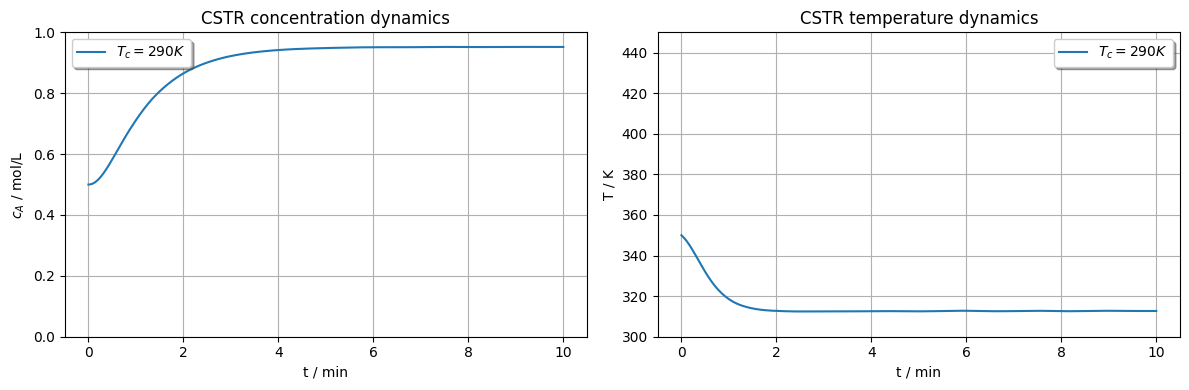

In [13]:
# Reactor dynamics for an increase in the CSTR cooling rate
T_c_bar = 290
t_eval, y = cstr_sim((f, (c_A_bar, T_bar, T_c_bar)))
cstr_plot((t_eval, y, T_c_bar))

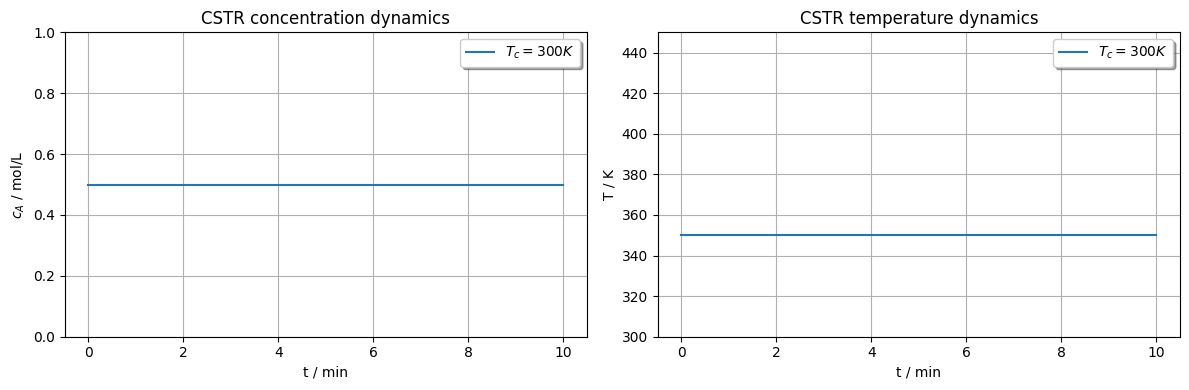

In [14]:
# Reactor dynamics for the nominal CSTR cooling rate
T_c_bar = 300
t_eval, y = cstr_sim((f, (c_A_bar, T_bar, T_c_bar)))
cstr_plot((t_eval, y, T_c_bar))

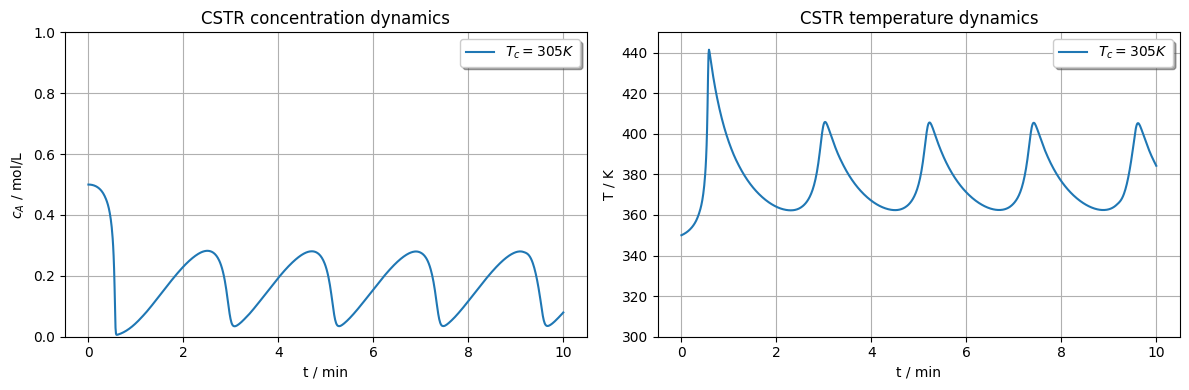

In [15]:
# Reactor dynamics for an decrease in the CSTR cooling rate
T_c_bar = 305
t_eval, y = cstr_sim((f, (c_A_bar, T_bar, T_c_bar)))
cstr_plot((t_eval, y, T_c_bar))

Compare these graphs with Figures 2.7 and 2.8 from Seborg 4<sup>th</sup> ed. p. 27.

In [ ]:
#!pip install tbcontrol
import tbcontrol.symbolic

In [ ]:
terms = [c_A_dot_.rhs, T_dot_.rhs]
variables = [c_A, T, T_c]
dev_variables = c_A_l, T_l, T_c_l = symbols("c'_A, T', T'_c")
linearexpression_ = []
for term in terms:
  bars, linearexpression = tbcontrol.symbolic.linearise(term, variables)
  linearexpression_.append(linearexpression.subs({
                                                  (c_A - bars[0]): c_A_l,
                                                  (T - bars[1]): T_l,
                                                  (T_c - bars[2]): T_c_l}).subs({
                                                      bars[0]:0.5,
                                                      bars[1]:350,
                                                      bars[2]:300,
                                                      V:100.0,
                                                      k_0:7.2e10,
                                                      EoverR:8750.0,
                                                      q:100.0,
                                                      c_Ai:1.0,
                                                      T_i:350.0,
                                                      C:0.239,
                                                      UA:5.0e4,
                                                      rho:1000.0,
                                                      DHR:5.0e4
                                                  }))

In [ ]:
linearexpression_[0]

-0.0357118556527646*T' - 1.99993195827741*c'_A + 3.40208612952253e-5

In [ ]:
linearexpression_[1]

4.37904929974155*T' + 2.09205020920502*T'_c + 209.190786250504*c'_A - 0.00711733499899481